# LDA
Modelamiento de Tópicos con LDA (Latent Dirichet Allocation) para categorías de la base Barómetro Migrante

# Procesamiento de texto a través spaCy
Si usted no posee una GPU, no intente correr ninguno de los paquetes que se instalan por !pip. Se le hará una lista de requisitos y formas para correr con exito spaCy desde una GPU con arquitectura Turing:
 1. Instale la versión y el paquete de spaCy en Español para procesar texto en este lenguaje
 2. La versión de CUDA es 11.0, válido para GPUs NVIDIA con versión cuDNN 8.0+. Esto lo necesita su equipo para asignar la memoria a la tarjeta gráfica. Se instala por fuera de Python [CUDA](https://developer.nvidia.com/cuda-downloads).
 3. Instale la versión de Pytorch compatible con su versión de CUDA, recuerde que spaCy tiene transformers, esto tiene que estar especificado para que descargue los paquetes de clasificación
 4. Thinc GPU OPS y CuPy son necesarios para que el equipo reconozca la tarjeta gráfica y la vuelva accesible desde Jupyter.
 
Con esto podrá iniciar a correr modelos complejos en su equipo de trabajo, recuerde que no debe de correr ninguna línea que instale un paquete.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
'''
!pip install lda2vec
!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis
!pip install tensorflow
!pip install keras
!pip install -U pip setuptools wheel
!pip install -U spacy[cuda110,transformers,lookups]
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm
!python -m spacy download es_dep_news_trf
!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --user
!pip install cupy-cuda110
!pip install thinc-gpu-ops
!pip install gensim
!pip install -q wordcloud
!python --version
!pip install --upgrade gensim
!pip install spacy_spanish_lemmatizer
!python -m spacy_spanish_lemmatizer download wiki
!pip install python-Levenshtein
'''

'\n!pip install lda2vec\n!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis\n!pip install tensorflow\n!pip install keras\n!pip install -U pip setuptools wheel\n!pip install -U spacy[cuda110,transformers,lookups]\n!python -m spacy download es_core_news_sm\n!python -m spacy download en_core_web_sm\n!python -m spacy download es_dep_news_trf\n!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --user\n!pip install cupy-cuda110\n!pip install thinc-gpu-ops\n!pip install gensim\n!pip install -q wordcloud\n!python --version\n!pip install --upgrade gensim\n!pip install spacy_spanish_lemmatizer\n!python -m spacy_spanish_lemmatizer download wiki\n!pip install python-Levenshtein\n'

In [2]:
#Espacio de trabajo
import tqdm
import numpy as np
from numpy.random import seed
from numpy.random import randint
#import lda2vec as l2v
import gensim
from gensim import corpora, similarities, models
from gensim.models.phrases import Phraser
#from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn
except:
    pass
import sys
import pandas as pd
import spacy
from spacy_spanish_lemmatizer import SpacyCustomLemmatizer
import wordcloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import re
import logging
import pyLDAvis
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

C:\Users\JOSE\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\JOSE\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps

In [3]:
base_entera = pd.read_excel('El_Salvador_Xenofobia.xlsx')
base_entera

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,Language,...,Twitter Screen Name,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags
0,01-Apr-2021 11:41PM,NaN,http://twitter.com/DonChampero/statuses/137784...,NaN,Yo siempre pensé que el cara de nuegado era es...,Twitter,donchampero,El Salvador,NaN,Spanish / Castilian,...,Don Champero,http://www.twitter.com/DonChampero,Cobrador de microbús de profesion y comentaris...,10816.0,10814.0,"Apr 1, 2021",23:41:00,San Salvador,San Salvador,NaN
1,01-Apr-2021 11:19PM,NaN,https://twitter.com/fermi_enriqo/statuses/1377...,NaN,"@cigarra933 Veneco lacra, a todas luces",Twitter,fermi_enriqo,El Salvador,NaN,Spanish / Castilian,...,Fernando 💘,https://twitter.com/fermi_enriqo,Físico | La música ecualiza mis días y los lib...,35.0,683.0,"Apr 1, 2021",23:19:00,San Miguel,San Miguel,NaN
2,01-Apr-2021 10:53PM,NaN,http://twitter.com/Alondra41719354/statuses/13...,NaN,RT @JavierGaldame17: @VenturaFenix ESTA CHAPIN...,Twitter,alondra41719354,El Salvador,NaN,Spanish / Castilian,...,Alondra,http://www.twitter.com/Alondra41719354,"Pro El Salvador, por eso, \nARENA y FMLN nunca...",1003.0,850.0,"Apr 1, 2021",22:53:00,San Salvador,San Salvador,NaN
3,01-Apr-2021 10:16PM,NaN,https://twitter.com/spencynews/statuses/137782...,NaN,"@PabloQuijano26 Sabes que es lo peor, que esos...",Twitter,spencynews,El Salvador,NaN,Spanish / Castilian,...,Mapache Run 4 U Life 🦝,https://twitter.com/spencynews,"Si pudiera elegir cómo morir, escojo: 'Muerte ...",579.0,1108.0,"Apr 1, 2021",22:16:00,San Salvador,San Salvador,NaN
4,01-Apr-2021 09:51PM,NaN,http://twitter.com/Gaboqzuu/statuses/137781605...,NaN,RT @Debbie_GomezP: Los hondureños simulan la m...,Twitter,gaboqzuu,El Salvador,NaN,Spanish / Castilian,...,Alexis Flores,http://www.twitter.com/Gaboqzuu,"Comunicador en Proceso,\nAnimador de Eventos M...",272.0,521.0,"Apr 1, 2021",21:51:00,San Salvador,San Salvador,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12139,18-Apr-2020 08:02PM,NaN,https://twitter.com/iTsmeinsanee/statuses/1251...,NaN,Que es un veneco?,Twitter,itsmeinsanee,El Salvador,NaN,Spanish / Castilian,...,it's me 🎧 🐕,https://twitter.com/iTsmeinsanee,@Twitter adicto 🐥💬 / leer un libro es vivir / ...,634.0,1455.0,"Apr 18, 2020",20:02:00,Cuscatlán,San Martín,NaN
12140,18-Apr-2020 07:48PM,NaN,https://twitter.com/gdanielquijano/statuses/12...,NaN,RT @laplatero4: Este médico es hondureño! Sus ...,Twitter,gdanielquijano,El Salvador,NaN,Spanish / Castilian,...,Daniel Quijano,https://twitter.com/gdanielquijano,Deseo ser conforme al corazón de Jehova!,191.0,572.0,"Apr 18, 2020",19:48:00,Cuscatlán,San Martín,NaN
12141,13-Apr-2020 11:17AM,Varias hectáreas de un bosque en Honduras son ...,https://cronio.sv/internacionales/varias-hecta...,Un incendio de grandes proporciones consumió l...,"de bosque en el sector de La Montañita, al ori...",Cronio.sv,Redaccion Cronio,El Salvador,NaN,Spanish / Castilian,...,NaN,NaN,NaN,NaN,NaN,"Apr 13, 2020",11:17:00,NaN,NaN,NaN
12142,07-Apr-2020 06:00PM,"Honduras exportó $468.6 millones en café, 10.7...",https://www.eleconomista.net/actualidad/Hondur...,Las exportaciones de café hondureño aumentaron...,Las exportaciones de café hondureño aumentaron...,El Economista,EFE,El Salvador,NaN,Spanish / Castilian,...,NaN,NaN,NaN,NaN,NaN,"Apr 7, 2020",18:00:00,NaN,NaN,NaN


In [4]:
#df = base_entera[base_entera['Xenofobia'] == 1]
df = base_entera
# Remover el QT y el RTs por contexto
def meltwater_QT_and_RT_remover(df):
    df['RT'] = df['Hit Sentence'].astype(str).str.find('RT')
    df['QT'] = df['Hit Sentence'].astype(str).str.find('QT')
    # Remove authors
    df['Snippet'] = df['Hit Sentence'].replace(r'@\w+', '', regex=True)
    # Manejar QT con RT
    'QT @author: ... RT @author2: ...'
    df.loc[(df['RT'] != -1) & (df['QT'] != -1), 'Snippet'] = df['Snippet'].str.extract(r'QT(.*)RT')[0]
    # Manejar QT sin RT
    'QT @author: ...'
    df.loc[(df['RT'] == -1) & (df['QT'] != -1), 'Snippet'] = df['Snippet'].str.extract(r'QT(.*)\;')[0]
    # Manejar RT sin QT
    'RT @author: ...'
    df.loc[(df['RT'] != -1) & (df['QT'] == -1), 'Snippet'] = df['Snippet'].replace(r'[RT].*$', '', regex = True)
    df['Snippet'] = df['Snippet'].replace(r'\:', '', regex=True)
    df['Snippet'] = df['Snippet'].replace("", np.nan)
    df['Snippet'] = df['Snippet'].replace('  ', np.nan)
    print(df[['QT','RT','Hit Sentence','Snippet']].head(25))
    df = df.dropna(subset=['Snippet'])
    df = df.drop(columns=['RT', 'QT'])
    return df
df = meltwater_QT_and_RT_remover(df)

    QT  RT                                       Hit Sentence  \
0   -1  -1  Yo siempre pensé que el cara de nuegado era es...   
1   -1  -1            @cigarra933 Veneco lacra, a todas luces   
2   -1   0  RT @JavierGaldame17: @VenturaFenix ESTA CHAPIN...   
3   -1  -1  @PabloQuijano26 Sabes que es lo peor, que esos...   
4   -1   0  RT @Debbie_GomezP: Los hondureños simulan la m...   
5   -1  -1  @waraujo64 Mi no entender esa vieja chapina. E...   
6   -1   0  RT @Omega75436305: @waraujo64 Esta chapina est...   
7   -1  -1  #Internacionales | La ONG hondureña Jóvenes Co...   
8    0  -1  QT @JoseValdezSV: Mas perdida qud chucho en mi...   
9   -1   0  RT @chinchontepec22: #Internacionales || El pr...   
10  -1  -1  @miguelbolanos2 @Chomingo_ Hahahahahaha ese es...   
11  -1  -1  @prensagrafica Si los evasores celebran ésto, ...   
12  -1  -1  #Internacionales || El presidente de la Asocia...   
13  -1  -1  @CADC_CDAguila16 Conclusión este año nos empat...   
14  -1  -1  @amadeo1980 P

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
seed(1)
values = list(set(randint(0, 22255, 500)))

temp=df.loc[df.index.isin(values)]
print(len(temp))
del values

temp.head()

111


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,Language,...,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags,Snippet
20,01-Apr-2021 10:58AM,NaN,https://twitter.com/engelsoy/statuses/13776516...,NaN,@sonyvillasegura Eres Chapina???,Twitter,engelsoy,El Salvador,NaN,Spanish / Castilian,...,https://twitter.com/engelsoy,De cara al sol caminare y con la luna volare...,71.0,263.0,"Apr 1, 2021",10:58:00,NaN,NaN,NaN,Eres Chapina???
42,31-Mar-2021 05:22PM,NaN,https://twitter.com/diario1_sv/statuses/137738...,NaN,¡HISTÓRICO! 🇵🇦🇸🇻 Así festejó el delantero de @...,Twitter,diario1_sv,El Salvador,NaN,Spanish / Castilian,...,https://twitter.com/diario1_sv,Hacemos periodismo sin límites · Queremos que ...,193654.0,703.0,"Mar 31, 2021",17:22:00,NaN,NaN,NaN,"¡HISTÓRICO! 🇵🇦🇸🇻 Así festejó el delantero de ,..."
174,28-Mar-2021 11:43PM,NaN,http://twitter.com/Overlord_ains1/statuses/137...,NaN,@FunesCartagena que chinga este bolo hijo de p...,Twitter,overlord_ains1,El Salvador,NaN,Spanish / Castilian,...,http://www.twitter.com/Overlord_ains1,"Anime, NI y Metal lml",681.0,797.0,"Mar 28, 2021",23:43:00,NaN,NaN,NaN,que chinga este bolo hijo de puta! los nicas ...
269,26-Mar-2021 09:58PM,NaN,https://twitter.com/Misael_cgz/statuses/137564...,NaN,QT @RepMattGaetz: dinero a los migrantes hondu...,Twitter,misael_cgz,El Salvador,NaN,Spanish / Castilian,...,https://twitter.com/Misael_cgz,NaN,2174.0,1398.0,"Mar 26, 2021",21:58:00,NaN,NaN,NaN,dinero a los migrantes hondureños para unirs...
312,25-Mar-2021 05:22PM,NaN,https://twitter.com/serolando7/statuses/137521...,NaN,@FunesCartagena Lo que les quedó es el or........,Twitter,serolando7,El Salvador,NaN,Spanish / Castilian,...,https://twitter.com/serolando7,"Si quieres cambio verdadero, hay que caminar d...",132.0,766.0,"Mar 25, 2021",17:22:00,NaN,NaN,NaN,Lo que les quedó es el or......oo buen ondo p...


In [6]:
#Eliminamos los URL: Todo lo que empieza por  HTTP
df['Clean_Text']=df['Snippet'].replace(r"http\S+", '', regex=True)
#Eliminamos todos los hashtags
df['Clean_Text']=df['Clean_Text'].replace('#\\w+', '', regex=True)
#Eliminamos los signos de puntuación repetidos dentro de los tweets
df['Clean_Text']=df['Clean_Text'].replace(r'([^0-9a-zA-Z])\1+', r'\1', regex=True)
#Eliminamos los signos de puntuación al inicio de un tweet
df['Clean_Text']=df['Clean_Text'].replace(r'^[^0-9a-zA-Z@#]+', '', regex=True)
#Eliminamos los dobles espacios
df['Clean_Text']=df['Clean_Text'].replace(r'()\1+', r'\1\1', regex=True)
#Eliminamos las letras repetivas dentro de las palabras
df['Clean_Text']=df['Clean_Text'].replace(r'(.)\1+', r'\1\1', regex=True)
# Quitar las comillas de los textos
df['Clean_Text']=df['Clean_Text'].replace('"', '', regex=True)
# Remover puntuaciones innecesarias
df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Remover mayúsculas de inicio de texto
df['Clean_Text'] = df['Clean_Text'].map(lambda x: x.lower())
df=df.reset_index(drop=True)
df=df.reset_index()
df = df.astype({"Clean_Text": str})
df.head(11)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:16: DeprecationWarning: invalid escape sequence \.
<>:16: DeprecationWarning: invalid escape sequence \.
<ipython-input-6-85578270f296>:16: DeprecationWarning: invalid escape sequence \.
  df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', x))


,index,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,...,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags,Snippet,Clean_Text
0,0,01-Apr-2021 11:41PM,NaN,http://twitter.com/DonChampero/statuses/137784...,NaN,Yo siempre pensé que el cara de nuegado era es...,Twitter,donchampero,El Salvador,NaN,...,Cobrador de microbús de profesion y comentaris...,10816.0,10814.0,"Apr 1, 2021",23:41:00,San Salvador,San Salvador,NaN,Yo siempre pensé que el cara de nuegado era es...,yo siempre pensé que el cara de nuegado era es...
1,1,01-Apr-2021 11:19PM,NaN,https://twitter.com/fermi_enriqo/statuses/1377...,NaN,"@cigarra933 Veneco lacra, a todas luces",Twitter,fermi_enriqo,El Salvador,NaN,...,Físico | La música ecualiza mis días y los lib...,35.0,683.0,"Apr 1, 2021",23:19:00,San Miguel,San Miguel,NaN,"Veneco lacra, a todas luces",veneco lacra a todas luces
2,2,01-Apr-2021 10:16PM,NaN,https://twitter.com/spencynews/statuses/137782...,NaN,"@PabloQuijano26 Sabes que es lo peor, que esos...",Twitter,spencynews,El Salvador,NaN,...,"Si pudiera elegir cómo morir, escojo: 'Muerte ...",579.0,1108.0,"Apr 1, 2021",22:16:00,San Salvador,San Salvador,NaN,"Sabes que es lo peor, que esos cerotes chapin...",sabes que es lo peor que esos cerotes chapines...
3,3,01-Apr-2021 09:34PM,NaN,https://twitter.com/mariancelma_mm/statuses/13...,NaN,@waraujo64 Mi no entender esa vieja chapina. E...,Twitter,mariancelma_mm,El Salvador,NaN,...,➡️Bachiller en letras. ➡️Bachiller en Admón de...,686.0,816.0,"Apr 1, 2021",21:34:00,San Miguel,San Miguel,NaN,Mi no entender esa vieja chapina. Estar loco ...,mi no entender esa vieja chapina estar loco lo...
4,4,01-Apr-2021 09:00PM,NaN,https://twitter.com/prensagrafica/statuses/137...,NaN,#Internacionales | La ONG hondureña Jóvenes Co...,Twitter,prensagrafica,El Salvador,NaN,...,Cuenta oficial del periódico La Prensa Gráfica...,863852.0,14384.0,"Apr 1, 2021",21:00:00,San Salvador,San Salvador,NaN,#Internacionales | La ONG hondureña Jóvenes Co...,la ong hondureña jóvenes contra la violencia b...
5,5,01-Apr-2021 08:15PM,NaN,http://twitter.com/DARIOVA35498204/statuses/13...,NaN,QT @JoseValdezSV: Mas perdida qud chucho en mi...,Twitter,dariova35498204,El Salvador,NaN,...,MIS FIRMES CONVICCIONES,692.0,382.0,"Apr 1, 2021",20:15:00,Santa Ana,Santa Ana,NaN,Mas perdida qud chucho en misa. Debe de ente...,mas perdida qud chucho en misa debe de entende...
6,6,01-Apr-2021 07:06PM,NaN,https://twitter.com/Leonardo_Guirol/statuses/1...,NaN,@miguelbolanos2 @Chomingo_ Hahahahahaha ese es...,Twitter,leonardo_guirol,El Salvador,NaN,...,"Satan acuerdate de mi, cuando el fin esté cerca.",87.0,90.0,"Apr 1, 2021",19:06:00,San Salvador,San Salvador,NaN,Hahahahahaha ese es tu nivel el los chapines...,hahahahahaha ese es tu nivel el los chapines t...
7,7,01-Apr-2021 07:04PM,NaN,https://twitter.com/ElizabethGect/statuses/137...,NaN,"@prensagrafica Si los evasores celebran ésto, ...",Twitter,elizabethgect,El Salvador,NaN,...,La Arqui 😎,285.0,404.0,"Apr 1, 2021",19:04:00,San Salvador,San Salvador,NaN,"Si los evasores celebran ésto, es que esta ch...",si los evasores celebran ésto es que esta chap...
8,8,01-Apr-2021 06:20PM,NaN,http://twitter.com/chinchontepec22/statuses/13...,NaN,#Internacionales || El presidente de la Asocia...,Twitter,chinchontepec22,El Salvador,NaN,...,The man.,45853.0,5459.0,"Apr 1, 2021",18:20:00,San Salvador,San Salvador,NaN,#Internacionales || El presidente de la Asocia...,el presidente de la asociación de médicos del ...
9,9,01-Apr-2021 06:15PM,NaN,https://twitter.com/yony_quiros/statuses/13777...,NaN,@CADC_CDAguila16 Conclusión este año nos empat...,Twitter,yony_quiros,El Salvador,NaN,...,http://facebook.com/yonyQuiros ...,500.0,1496.0,"Apr 1, 2021",18:15:00,San Miguel,San Miguel,NaN,"Conclusión este año nos empatan en títulos, y...",conclusión este año nos empatan en títulos y a...


In [7]:
df['Clean_Text']=df['Clean_Text'].str.strip()
df['Clean_Text'] = df['Clean_Text'].replace("", np.nan)
df = df.dropna(subset=['Clean_Text'])
df

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,...,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags,Snippet,Clean_Text
0,0,01-Apr-2021 11:41PM,NaN,http://twitter.com/DonChampero/statuses/137784...,NaN,Yo siempre pensé que el cara de nuegado era es...,Twitter,donchampero,El Salvador,NaN,...,Cobrador de microbús de profesion y comentaris...,10816.0,10814.0,"Apr 1, 2021",23:41:00,San Salvador,San Salvador,NaN,Yo siempre pensé que el cara de nuegado era es...,yo siempre pensé que el cara de nuegado era es...
1,1,01-Apr-2021 11:19PM,NaN,https://twitter.com/fermi_enriqo/statuses/1377...,NaN,"@cigarra933 Veneco lacra, a todas luces",Twitter,fermi_enriqo,El Salvador,NaN,...,Físico | La música ecualiza mis días y los lib...,35.0,683.0,"Apr 1, 2021",23:19:00,San Miguel,San Miguel,NaN,"Veneco lacra, a todas luces",veneco lacra a todas luces
2,2,01-Apr-2021 10:16PM,NaN,https://twitter.com/spencynews/statuses/137782...,NaN,"@PabloQuijano26 Sabes que es lo peor, que esos...",Twitter,spencynews,El Salvador,NaN,...,"Si pudiera elegir cómo morir, escojo: 'Muerte ...",579.0,1108.0,"Apr 1, 2021",22:16:00,San Salvador,San Salvador,NaN,"Sabes que es lo peor, que esos cerotes chapin...",sabes que es lo peor que esos cerotes chapines...
3,3,01-Apr-2021 09:34PM,NaN,https://twitter.com/mariancelma_mm/statuses/13...,NaN,@waraujo64 Mi no entender esa vieja chapina. E...,Twitter,mariancelma_mm,El Salvador,NaN,...,➡️Bachiller en letras. ➡️Bachiller en Admón de...,686.0,816.0,"Apr 1, 2021",21:34:00,San Miguel,San Miguel,NaN,Mi no entender esa vieja chapina. Estar loco ...,mi no entender esa vieja chapina estar loco lo...
4,4,01-Apr-2021 09:00PM,NaN,https://twitter.com/prensagrafica/statuses/137...,NaN,#Internacionales | La ONG hondureña Jóvenes Co...,Twitter,prensagrafica,El Salvador,NaN,...,Cuenta oficial del periódico La Prensa Gráfica...,863852.0,14384.0,"Apr 1, 2021",21:00:00,San Salvador,San Salvador,NaN,#Internacionales | La ONG hondureña Jóvenes Co...,la ong hondureña jóvenes contra la violencia b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5276,5276,18-Apr-2020 08:04PM,NaN,https://twitter.com/iTsmeinsanee/statuses/1251...,NaN,@luminisciente 😱 no sabía pensé era alguien ve...,Twitter,itsmeinsanee,El Salvador,NaN,...,@Twitter adicto 🐥💬 / leer un libro es vivir / ...,634.0,1455.0,"Apr 18, 2020",20:04:00,Cuscatlán,San Martín,NaN,😱 no sabía pensé era alguien venezolano en Co...,no sabía pensé era alguien venezolano en colom...
5277,5277,18-Apr-2020 08:02PM,NaN,https://twitter.com/iTsmeinsanee/statuses/1251...,NaN,Que es un veneco?,Twitter,itsmeinsanee,El Salvador,NaN,...,@Twitter adicto 🐥💬 / leer un libro es vivir / ...,634.0,1455.0,"Apr 18, 2020",20:02:00,Cuscatlán,San Martín,NaN,Que es un veneco?,que es un veneco
5278,5278,13-Apr-2020 11:17AM,Varias hectáreas de un bosque en Honduras son ...,https://cronio.sv/internacionales/varias-hecta...,Un incendio de grandes proporciones consumió l...,"de bosque en el sector de La Montañita, al ori...",Cronio.sv,Redaccion Cronio,El Salvador,NaN,...,NaN,NaN,NaN,"Apr 13, 2020",11:17:00,NaN,NaN,NaN,"de bosque en el sector de La Montañita, al ori...",de bosque en el sector de la montañita al orie...
5279,5279,07-Apr-2020 06:00PM,"Honduras exportó $468.6 millones en café, 10.7...",https://www.eleconomista.net/actualidad/Hondur...,Las exportaciones de café hondureño aumentaron...,Las exportaciones de café hondureño aumentaron...,El Economista,EFE,El Salvador,NaN,...,NaN,NaN,NaN,"Apr 7, 2020",18:00:00,NaN,NaN,NaN,Las exportaciones de café hondureño aumentaron...,las exportaciones de café hondureño aumentaron...


In [8]:
from tqdm import tqdm
# Le decimos a spaCy que vamos con toda
#spacy.prefer_gpu()
#spacy.require_gpu()
# Corremos los datos en el core de español
#nlp = spacy.load("es_core_news_sm", exclude=["ner", "parser"])
nlp = spacy.load("es_dep_news_trf", exclude=["ner", "parser", "lemmatizer"])
lemmatizer_spa = SpacyCustomLemmatizer()
nlp.add_pipe("spanish_lemmatizer", name = 'lemmatizer', after = 'attribute_ruler')
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
#Vemos cuales son los componentes del pipeline
print(nlp.pipe_names)
#Aplicamos el pipe a cada objeto de nuestra lista de tweets
print('---------SPACY-----------')
docs = list()
sentences = df.Clean_Text.to_list()
for doc in tqdm(nlp.pipe(sentences), total=len(sentences)):
    docs.append(doc)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/5259 [00:00<?, ?it/s]

['transformer', 'morphologizer', 'attribute_ruler', 'lemmatizer']
---------SPACY-----------


100%|██████████| 5259/5259 [21:12<00:00,  4.13it/s]  


In [9]:
print('---------TOKENIZATION-----------')
tokens=[]
for doc in docs:
    tokens.append([(token.text) for token in doc])

tokens=np.array(tokens)
tokens=pd.DataFrame(tokens).reset_index()
tokens.columns=['index', 'tokens']

tokens.head()
print('---------POS-----------')
pos=[]
for doc in docs:
    pos.append([(token.text, token.pos_) for token in doc])

pos=np.array(pos)
pos=pd.DataFrame(pos).reset_index()
pos.columns=['index', 'pos']
df=pd.merge(df, tokens, how='inner', on='index')
df=pd.merge(df, pos, how='inner', on='index')
print('---------STOPWORDS-----------')
spanish_stopwords=stopwords.words('spanish')
spanish_stopwords.extend(['ser', 'haber'])
#spanish_stopwords.extend(usuarios)
spanish_stopwords.remove('no')
spanish_stopwords.remove('ni')
# ,'venezolano', 'venezolanos', 'venezolana', 'venezolanas', 'veneco', 'veneca', 'venecos', 'venecas'
%time df['words']=df['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() and token.lower() not in spanish_stopwords and len(token)>1])
#N-GRAMS
tokens = df['words'].tolist()
bigram_model = gensim.models.phrases.Phrases(tokens, min_count=5, threshold=20)
trigram_model = gensim.models.phrases.Phrases(bigram_model[tokens], min_count=2, threshold=20)
tokens = list(trigram_model[bigram_model[tokens]])
print('---------N-GRAMS-----------')
print(trigram_model[bigram_model[tokens[0]]])
print('---------LEMMATIZER-----------')
lemma=[]
for doc in docs:
    lemma.append([(token.lemma_) for token in doc])
data_lemmatized = lemma
lemma=np.array(lemma)
lemma=pd.DataFrame(lemma).reset_index()
lemma.columns=['index', 'lemmatized']

print('---------Datos lemmatized-----------')
print(lemma[:1])

#MERGE LISTS INTO DF
df=pd.merge(df, lemma, how='inner', on='index')
df=df.drop(['index'], axis=1)

print('---------STOPWORDS-----------')
%time df['lem_words']=df['lemmatized'].map(lambda tokens: [token.lower() for token in tokens if token.lower() not in spanish_stopwords and len(token)>1])

print('--------BASE-FINAL--------')
df.head(11)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)
<ipython-input-9-4840286fbbb3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating 

---------TOKENIZATION-----------
---------POS-----------
---------STOPWORDS-----------
Wall time: 225 ms
---------N-GRAMS-----------
['siempre', 'pensé', 'cara', 'nuegado', 'especial', 'falta', 'toston', 'peso', 'nadie', 'mundo', 'no', 'encontramos', 'chapina', 'coeficiente', 'intelectual', 'igual', 'profe', 'congresista', 'usa', 'cosa_seria']
---------LEMMATIZER-----------
---------Datos lemmatized-----------
   index                                         lemmatized
0      0  [yo, siempre, pensar, que, el, cara, de, nuega...
---------STOPWORDS-----------


<ipython-input-9-4840286fbbb3>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lemma=np.array(lemma)


Wall time: 380 ms
--------BASE-FINAL--------


,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,Language,...,State,City,Document Tags,Snippet,Clean_Text,tokens,pos,words,lemmatized,lem_words
0,01-Apr-2021 11:41PM,NaN,http://twitter.com/DonChampero/statuses/137784...,NaN,Yo siempre pensé que el cara de nuegado era es...,Twitter,donchampero,El Salvador,NaN,Spanish / Castilian,...,San Salvador,San Salvador,NaN,Yo siempre pensé que el cara de nuegado era es...,yo siempre pensé que el cara de nuegado era es...,"[yo, siempre, pensé, que, el, cara, de, nuegad...","[(yo, PRON), (siempre, ADV), (pensé, VERB), (q...","[siempre, pensé, cara, nuegado, especial, falt...","[yo, siempre, pensar, que, el, cara, de, nuega...","[siempre, pensar, cara, nuegado, especial, fal..."
1,01-Apr-2021 11:19PM,NaN,https://twitter.com/fermi_enriqo/statuses/1377...,NaN,"@cigarra933 Veneco lacra, a todas luces",Twitter,fermi_enriqo,El Salvador,NaN,Spanish / Castilian,...,San Miguel,San Miguel,NaN,"Veneco lacra, a todas luces",veneco lacra a todas luces,"[veneco, lacra, a, todas, luces]","[(veneco, ADJ), (lacra, ADJ), (a, ADP), (todas...","[veneco, lacra, todas, luces]","[veneco, lacra, a, todo, luz]","[veneco, lacra, luz]"
2,01-Apr-2021 10:16PM,NaN,https://twitter.com/spencynews/statuses/137782...,NaN,"@PabloQuijano26 Sabes que es lo peor, que esos...",Twitter,spencynews,El Salvador,NaN,Spanish / Castilian,...,San Salvador,San Salvador,NaN,"Sabes que es lo peor, que esos cerotes chapin...",sabes que es lo peor que esos cerotes chapines...,"[sabes, que, es, lo, peor, que, esos, cerotes,...","[(sabes, VERB), (que, SCONJ), (es, AUX), (lo, ...","[sabes, peor, cerotes, chapines, andan, mas, h...","[saber, que, es, lo, peor, que, ese, cerote, c...","[saber, peor, cerote, chapines, andar, mas, ho..."
3,01-Apr-2021 09:34PM,NaN,https://twitter.com/mariancelma_mm/statuses/13...,NaN,@waraujo64 Mi no entender esa vieja chapina. E...,Twitter,mariancelma_mm,El Salvador,NaN,Spanish / Castilian,...,San Miguel,San Miguel,NaN,Mi no entender esa vieja chapina. Estar loco ...,mi no entender esa vieja chapina estar loco lo...,"[mi, no, entender, esa, vieja, chapina, estar,...","[(mi, DET), (no, ADV), (entender, VERB), (esa,...","[no, entender, vieja, chapina, loco, loco]","[mi, no, entender, ese, vieja, chapina, estar,...","[no, entender, vieja, chapina, loco, loco]"
4,01-Apr-2021 09:00PM,NaN,https://twitter.com/prensagrafica/statuses/137...,NaN,#Internacionales | La ONG hondureña Jóvenes Co...,Twitter,prensagrafica,El Salvador,NaN,Spanish / Castilian,...,San Salvador,San Salvador,NaN,#Internacionales | La ONG hondureña Jóvenes Co...,la ong hondureña jóvenes contra la violencia b...,"[la, ong, hondureña, jóvenes, contra, la, viol...","[(la, DET), (ong, NOUN), (hondureña, ADJ), (jó...","[ong, hondureña, jóvenes, violencia, busca, ca...","[el, ong, hondureño, joven, contra, el, violen...","[ong, hondureño, joven, violencia, buscar, cam..."
5,01-Apr-2021 08:15PM,NaN,http://twitter.com/DARIOVA35498204/statuses/13...,NaN,QT @JoseValdezSV: Mas perdida qud chucho en mi...,Twitter,dariova35498204,El Salvador,NaN,Spanish / Castilian,...,Santa Ana,Santa Ana,NaN,Mas perdida qud chucho en misa. Debe de ente...,mas perdida qud chucho en misa debe de entende...,"[mas, perdida, qud, chucho, en, misa, debe, de...","[(mas, CCONJ), (perdida, ADJ), (qud, NOUN), (c...","[mas, perdida, qud, chucho, misa, debe, entend...","[mas, perdida, qud, chucho, en, misa, debe, de...","[mas, perdida, qud, chucho, misa, debe, entend..."
6,01-Apr-2021 07:06PM,NaN,https://twitter.com/Leonardo_Guirol/statuses/1...,NaN,@miguelbolanos2 @Chomingo_ Hahahahahaha ese es...,Twitter,leonardo_guirol,El Salvador,NaN,Spanish / Castilian,...,San Salvador,San Salvador,NaN,Hahahahahaha ese es tu nivel el los chapines...,hahahahahaha ese es tu nivel el los chapines t...,"[hahahahahaha, ese, es, tu, nivel, el, los, ch...","[(hahahahahaha, INTJ), (ese, PRON), (es, AUX),...","[hahahahahaha, nivel, chapines, títulos, alian...","[hahahahahaha, ese, e

In [10]:
print(data_lemmatized[:1])
print(df.loc[0, 'lem_words'])
len(spanish_stopwords)

[['yo', 'siempre', 'pensar', 'que', 'el', 'cara', 'de', 'nuegado', 'era', 'especial', '(', 'le', 'faltar', 'toston', 'para', 'el', 'peso', ')', 'y', 'como', 'el', 'nadie', 'en', 'el', 'mundo', 'pero', 'no', 'encontrar', 'a', 'un', 'chapina', 'con', 'el', 'coeficiente', 'intelectual', 'igual', 'que', 'el', 'profe', 'y', 'es', 'congresista', 'el', 'la', 'usar', 'cosa', 'serio', '😂']]
['siempre', 'pensar', 'cara', 'nuegado', 'especial', 'faltar', 'toston', 'peso', 'nadie', 'mundo', 'no', 'encontrar', 'chapina', 'coeficiente', 'intelectual', 'igual', 'profe', 'congresista', 'usar', 'cosa', 'serio']


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


313

In [11]:
data_lemmatized=list(df['lem_words'])
dictionary = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
dictionary.save('tweets_x.dict');
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('tweets_x.mm', corpus)
corpora.SvmLightCorpus.serialize('tweets_x.svmlight', corpus)
corpora.BleiCorpus.serialize('tweets_x.lda-c', corpus)
corpora.LowCorpus.serialize('tweets_x.low', corpus)
print('--------CORPUS----------')
print(corpus[:1])
##Then the dictionary and corpus can be used to train using LDA
np.random.seed(123456)
mm = corpora.MmCorpus('tweets_x.mm')
num_topics=10
%time lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


--------CORPUS----------
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]
Wall time: 10.4 s


In [12]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


[[('cara', 1),
  ('chapina', 1),
  ('coeficiente', 1),
  ('congresista', 1),
  ('cosa', 1),
  ('encontrar', 1),
  ('especial', 1),
  ('faltar', 1),
  ('igual', 1),
  ('intelectual', 1),
  ('mundo', 1),
  ('nadie', 1),
  ('no', 1),
  ('nuegado', 1),
  ('pensar', 1),
  ('peso', 1),
  ('profe', 1),
  ('serio', 1),
  ('siempre', 1),
  ('toston', 1),
  ('usar', 1)]]

In [13]:
pprint(lda.print_topics())
doc_lda = lda[corpus]

[(0,
  '0.061*"hondureño" + 0.014*"tener" + 0.009*"chapines" + 0.008*"salvador" + '
  '0.008*"chapina" + 0.008*"bien" + 0.008*"salvadoreño" + 0.008*"no" + '
  '0.006*"hondureños" + 0.006*"hondura"'),
 (1,
  '0.047*"hondureño" + 0.019*"chapines" + 0.018*"no" + 0.012*"decir" + '
  '0.011*"hacer" + 0.010*"si" + 0.008*"tener" + 0.008*"salvadoreño" + '
  '0.007*"mismo" + 0.007*"ir"'),
 (2,
  '0.059*"hondureño" + 0.012*"país" + 0.011*"ingresar" + 0.009*"no" + '
  '0.008*"chapina" + 0.008*"salvadoreño" + 0.008*"tener" + 0.007*"ilegal" + '
  '0.007*"tratar" + 0.005*"fuerza"'),
 (3,
  '0.039*"no" + 0.036*"hondureño" + 0.014*"hacer" + 0.010*"país" + 0.009*"si" '
  '+ 0.008*"decir" + 0.008*"hondureños" + 0.008*"veneco" + 0.008*"salvadoreño" '
  '+ 0.007*"nicas"'),
 (4,
  '0.040*"no" + 0.032*"hondureño" + 0.030*"chapines" + 0.020*"tener" + '
  '0.014*"si" + 0.011*"hacer" + 0.009*"decir" + 0.009*"salvadoreño" + '
  '0.007*"solo" + 0.007*"nicas"'),
 (5,
  '0.059*"hondureño" + 0.014*"presidente" + 0.

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:

vis = pyLDAvis.gensim.prepare(topic_model=lda, corpus=corpus, dictionary=dictionary)
pyLDAvis.display(vis)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Archivo HTML
pyLDAvis.save_html(vis, 'ldax.html')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. Topic coherence score, in particular, has been more helpful.

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -8.789687047881614

Coherence Score:  0.3428487801925072


# LDA Mallet

In [17]:
'''
mallet_path = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet' # update this path
import os
os.environ['MALLET_HOME'] = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet-2.0.8'
print('----MALLET----')
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)
'''

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\nmallet_path = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet' # update this path\nimport os\nos.environ['MALLET_HOME'] = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet-2.0.8'\nprint('----MALLET----')\nldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)\n"

In [18]:
'''
# Convert mallet to gensim type
mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
# Compute Perplexity
print('\nPerplexity: ', mallet_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df['Clean_Text'].to_list(), dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
'''

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\n# Convert mallet to gensim type\nmallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)\n# Compute Perplexity\nprint('\nPerplexity: ', mallet_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.\n\n# Show Topics\npprint(ldamallet.show_topics(formatted=False))\n\n# Compute Coherence Score\ncoherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df['Clean_Text'].to_list(), dictionary=dictionary, coherence='c_v')\nwith np.errstate(invalid='ignore'):\n    coherence_ldamallet = coherence_model_ldamallet.get_coherence()\nprint('\nCoherence Score: ', coherence_ldamallet)\n"

# Optimal number of topics

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Can take a long time to run.
%time model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=mm, texts=data_lemmatized, start=4, limit=20, step=2)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 2min 35s


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


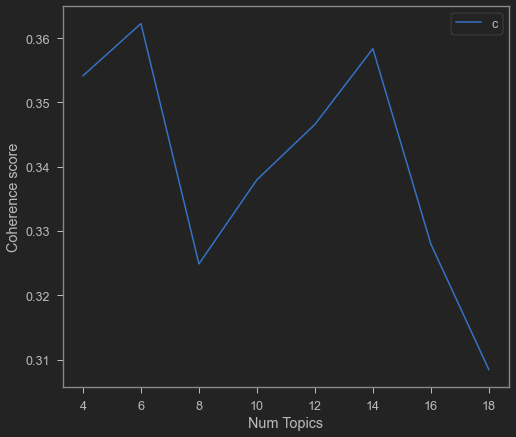

In [21]:
# Show graph
limit=20; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))

Num Topics = 4  has Coherence Value of 0.35
Num Topics = 6  has Coherence Value of 0.36
Num Topics = 8  has Coherence Value of 0.32
Num Topics = 10  has Coherence Value of 0.34
Num Topics = 12  has Coherence Value of 0.35
Num Topics = 14  has Coherence Value of 0.36
Num Topics = 16  has Coherence Value of 0.33
Num Topics = 18  has Coherence Value of 0.31


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.039*"hondureño" + 0.020*"ver" + 0.017*"no" + 0.015*"venecos" + '
  '0.014*"chapines" + 0.010*"solo" + 0.009*"tener" + 0.008*"creer" + '
  '0.008*"chapina" + 0.006*"querer"'),
 (1,
  '0.044*"hondureño" + 0.020*"no" + 0.009*"chapin" + 0.009*"chapina" + '
  '0.007*"dar" + 0.006*"tener" + 0.005*"caribe" + 0.005*"país" + '
  '0.005*"veneco" + 0.005*"nana"'),
 (2,
  '0.036*"chapines" + 0.026*"hondureño" + 0.018*"hondureños" + '
  '0.013*"salvadoreño" + 0.012*"no" + 0.011*"tener" + 0.007*"si" + '
  '0.007*"presidente" + 0.006*"bien" + 0.006*"medio"'),
 (3,
  '0.057*"hondureño" + 0.028*"no" + 0.012*"decir" + 0.011*"hacer" + '
  '0.008*"venir" + 0.008*"salvadoreño" + 0.008*"chapina" + 0.008*"si" + '
  '0.007*"pueblo" + 0.006*"solo"'),
 (4,
  '0.051*"hondureño" + 0.014*"tener" + 0.013*"salvadoreño" + 0.010*"país" + '
  '0.010*"no" + 0.007*"hondureños" + 0.006*"presidente" + 0.006*"hondura" + '
  '0.005*"chapines" + 0.005*"salvador"'),
 (5,
  '0.050*"hondureño" + 0.035*"no" + 0.014*"paí

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
visx = pyLDAvis.gensim.prepare(topic_model=optimal_model, corpus=corpus, dictionary=dictionary, mds='mmds')
pyLDAvis.display(visx)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\JOSE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning,

In [25]:
# Archivo HTML
pyLDAvis.save_html(visx, 'ldax2.html')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 540/540 [2:55:12<00:00, 19.47s/it]  


In [27]:
tabla_tunning = pd.read_csv('lda_tuning_results.csv')
tabla_tunning = tabla_tunning.sort_values(by = 'Coherence')
tabla_tunning

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Validation_Set,Topics,Alpha,Beta,Coherence
14,75% Corpus,2,0.61,symmetric,0.223868
11,75% Corpus,2,0.61,0.31,0.223868
13,75% Corpus,2,0.61,0.9099999999999999,0.223971
12,75% Corpus,2,0.61,0.61,0.228396
16,75% Corpus,2,0.9099999999999999,0.31,0.232682
...,...,...,...,...,...
238,75% Corpus,9,asymmetric,0.9099999999999999,0.476513
207,75% Corpus,8,asymmetric,0.61,0.506787
178,75% Corpus,7,asymmetric,0.9099999999999999,0.525954
208,75% Corpus,8,asymmetric,0.9099999999999999,0.555038


In [28]:
tabla_tunning.to_excel('mejor_modelo.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:


#corpus = corpora.MmCorpus('tweets_x.mm')
#dictionary = corpora.Dictionary('tweets_x.dict')
# EL mejor modelo
eta = 0.9099999999999999
lda_final_model = gensim.models.LdaMulticore(corpus=mm,
                                             id2word=dictionary,
                                             num_topics=4,
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha='asymmetric',
                                             eta=eta)

[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

pprint(lda_final_model.print_topics())
doc_lda = lda_final_model[corpus]

visxx = pyLDAvis.gensim.prepare(topic_model=lda_final_model, corpus=corpus, dictionary=dictionary)
pyLDAvis.display(visxx)


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


[(0,
  '0.038*"hondureño" + 0.024*"no" + 0.011*"chapines" + 0.010*"tener" + '
  '0.008*"hondureños" + 0.007*"país" + 0.007*"si" + 0.007*"hacer" + '
  '0.007*"decir" + 0.006*"salvadoreño"'),
 (1,
  '0.025*"hondureño" + 0.006*"salvador" + 0.003*"gol" + 0.002*"carlos" + '
  '0.002*"san" + 0.002*"presentar" + 0.002*"2020" + 0.002*"jocoro" + '
  '0.002*"tropical" + 0.002*"presidente"'),
 (2,
  '0.003*"hondureño" + 0.001*"social" + 0.001*"red" + 0.001*"rt" + 0.001*"18" '
  '+ 0.001*"samuel" + 0.001*"acosta" + 0.001*"pineda" + 0.001*"fas" + '
  '0.001*"pica"'),
 (3,
  '0.002*"the" + 0.001*"banda" + 0.001*"of" + 0.001*"venecas" + 0.001*"ixkal" '
  '+ 0.001*"álbum" + 0.001*"dalton" + 0.001*"end" + 0.001*"wicked" + '
  '0.001*"bla"')]


In [31]:
pyLDAvis.save_html(visxx, 'ldax3.html')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_final_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_final_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -8.168667523497964

Coherence Score:  0.4307625943474831


# Finding the dominant topic in each sentence

In [33]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_final_model, corpus=corpus, texts=df['Snippet'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9711,"hondureño, no, chapines, tener, hondureños, pa...",Yo siempre pensé que el cara de nuegado era es...
1,1,0.0,0.8428,"hondureño, no, chapines, tener, hondureños, pa...","Veneco lacra, a todas luces"
2,2,0.0,0.9478,"hondureño, no, chapines, tener, hondureños, pa...","Sabes que es lo peor, que esos cerotes chapin..."
3,3,0.0,0.9123,"hondureño, no, chapines, tener, hondureños, pa...",Mi no entender esa vieja chapina. Estar loco ...
4,4,0.0,0.9569,"hondureño, no, chapines, tener, hondureños, pa...",#Internacionales | La ONG hondureña Jóvenes Co...
5,5,0.0,0.5286,"hondureño, no, chapines, tener, hondureños, pa...",Mas perdida qud chucho en misa. Debe de ente...
6,6,0.0,0.9557,"hondureño, no, chapines, tener, hondureños, pa...",Hahahahahaha ese es tu nivel el los chapines...
7,7,0.0,0.9216,"hondureño, no, chapines, tener, hondureños, pa...","Si los evasores celebran ésto, es que esta ch..."
8,8,0.0,0.8910,"hondureño, no, chapines, tener, hondureños, pa...",#Internacionales || El presidente de la Asocia...
9,9,0.0,0.8963,"hondureño, no, chapines, tener, hondureños, pa...","Conclusión este año nos empatan en títulos, y..."


In [34]:
df_dominant_topic.to_excel('Topico_dominante_por_frase_snippet.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Find the most representative document for each topic

In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9862,"hondureño, no, chapines, tener, hondureños, pa...",El verdadero amor.
1,1.0,0.9725,"hondureño, salvador, gol, carlos, san, present...","Hola, saludos apreciable Hondureña"
2,2.0,0.9646,"hondureño, social, red, rt, 18, samuel, acosta...",#Honduras|| Han superado los 15 mil casos posi...
3,3.0,0.9326,"the, banda, of, venecas, ixkal, álbum, dalton,...",Cualquier Hondureño que diga q sigue apoyando...


In [36]:
sent_topics_sorteddf_mallet.to_excel('tweets_representativos_por_topico_snippet.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic distribution across documents

In [37]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"hondureño, no, chapines, tener, hondureños, pa...",4348.0,0.8301
1.0,0.0,"hondureño, no, chapines, tener, hondureños, pa...",569.0,0.1086
2.0,0.0,"hondureño, no, chapines, tener, hondureños, pa...",132.0,0.0252
3.0,0.0,"hondureño, no, chapines, tener, hondureños, pa...",189.0,0.0361
4.0,0.0,"hondureño, no, chapines, tener, hondureños, pa...",NaN,NaN
...,...,...,...,...
5233.0,0.0,"hondureño, no, chapines, tener, hondureños, pa...",NaN,NaN
5234.0,0.0,"hondureño, no, chapines, tener, hondureños, pa...",NaN,NaN
5235.0,0.0,"hondureño, no, chapines, tener, hondureños, pa...",NaN,NaN
5236.0,1.0,"hondureño, salvador, gol, carlos, san, present...",NaN,NaN


In [38]:
df_dominant_topics.to_excel('distribución_de_topicos_a_traves_de_documentos.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
